In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import argparse

In [2]:
# Check device
def get_default_device():
    if torch.cuda.is_available(): device = torch.device('cuda')
    else: device = torch.device('cpu')
    # print(device)
    return device

In [3]:
# Data transform and augmentation
def data_trans_and_aug():
    # train_tfms = transforms.Compose([   transforms.RandomCrop(32, padding=4),
    #                                     transforms.RandomHorizontalFlip(),
    #                                     transforms.ToTensor(),
    #                                     transforms.Normalize( mean = (0.4914, 0.4822, 0.4465),
    #                                                           std = (0.247, 0.243, 0.261))])
    train_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # 使用單通道的正規化
    ])
    valid_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # 使用單通道的正規化
    ])


    # valid_tfms = transforms.Compose([   transforms.ToTensor(),
    #                                     transforms.Normalize( mean = (0.4914, 0.4822, 0.4465),
    #                                                           std = (0.247, 0.243, 0.261))])
    return train_tfms, valid_tfms

In [4]:
# Test
def Test(model, device, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            val_loss += F.cross_entropy(out, labels).item()
            pred = out.argmax(dim=1, keepdim=True)
            val_acc += pred.eq(labels.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = (100. * val_acc) / len(val_loader.dataset)
    print('\nTest Set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
    return val_acc, val_loss

In [5]:
# Train
def Train(epochs, lr, model, device, train_loader, val_loader, save_path, resume):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # training setting
    best_acc = 0.
    start_epoch = 1
    results = {}
    results['train_loss'] = []
    results['train_accu'] = []
    results['valid_loss'] = []
    results['valid_accu'] = []
    # training resume
    if resume:
        assert os.path.isfile(resume)
        checkpoint = torch.load(resume)
        print('Loading checkpoint model...')
        model.load_state_dict(checkpoint['model_state_dict'])
        print('Loading checkpoint optimizer...')
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_acc = checkpoint['best_acc']
        start_epoch = checkpoint['epoch'] + 1
        print('Start at epoch', start_epoch, 'with the best accuracy: ' + str(best_acc) + ' %')

    # Start training
    for epoch in range(start_epoch, epochs+1):
        model.train()
        print('\n')
        epoch_loss = 0.
        train_acc = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            pred = out.argmax(dim=1, keepdim=True)
            train_acc += pred.eq(labels.view_as(pred)).sum().item()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

        train_acc = (100. * train_acc) / len(train_loader.dataset)
        results['train_loss'].append(epoch_loss/len(train_loader))
        results['train_accu'].append(train_acc)
        # Validataion
        val_acc, val_loss = Test(model, device, val_loader)
        results['valid_loss'].append(val_loss)
        results['valid_accu'].append(val_acc)
        # Save Checkpoint
        if val_acc > best_acc:
            best_acc = val_acc
            print('Saving checkpoint...')
            state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_acc': best_acc }
            if not os.path.isdir(save_path): os.mkdir(save_path)
            torch.save(state, save_path + 'checkpoint.pth')

    return results

In [6]:
import matplotlib.pyplot as plt
def plot_acc_and_lr(results):
  train_loss = results['train_loss']
  val_loss = results['valid_loss']
  plt.subplot(2,1,1)
  plt.plot(train_loss, "-o", label='train_loss')
  plt.plot(val_loss, "-x", label='val_loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss vs. Number of epochs')

  train_acc = results['train_accu']
  val_acc = results['valid_accu']
  plt.subplot(2,1,2)
  plt.plot(train_acc, "-o", label='train_acc')
  plt.plot(val_acc, "-x", label='val_acc')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title('Accuracy vs. Number of epochs')

  plt.tight_layout()

In [7]:
def testing_for_performance(test_dl, model, device):
  model.eval()
  batch_pred_prob = []
  batch_pred_label = []
  batch_label = []
  with torch.no_grad():
    for images, labels in test_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      pred_prob, pred_label = F.softmax(outputs, dim=1).max(1)
      batch_pred_prob.append(pred_prob.cpu())
      batch_pred_label.append(pred_label.cpu())
      batch_label.append(labels.cpu())
    return torch.cat(batch_label).numpy(), torch.cat(batch_pred_label).numpy()

from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
def performance(model, test_dl, device):
  labels, preds = testing_for_performance(test_dl, model, device)
  cm = metrics.confusion_matrix(labels, preds)
  accuracy = metrics.accuracy_score(labels, preds)
  precision = metrics.precision_score(labels, preds, average='macro')
  recall = metrics.recall_score(labels, preds, average='macro')
  F1_score = metrics.f1_score(labels, preds, average='macro')

  print("Accuracy:",accuracy)
  print("Precision:",precision)
  print("Recall:",recall)
  print('F1_score:',F1_score)
  cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4,5,6,7,8,9])
  cm_plot.plot()
  plt.show()

In [8]:
from torchvision.models import resnet18, ResNet18_Weights, resnet50
Net = resnet18(pretrained=True)

Net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


num_ftrs = Net.fc.in_features
Net.fc = nn.Linear(num_ftrs, 10)


for param in Net.parameters():
    param.requires_grad = False

flatten_feature = Net.fc.in_features
Net.fc = nn.Linear(flatten_feature, 10)

for name, param in Net.named_parameters():
    print(f'Parameter: {name}, Requires Grad: {param.requires_grad}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.5MB/s]


Parameter: conv1.weight, Requires Grad: False
Parameter: bn1.weight, Requires Grad: False
Parameter: bn1.bias, Requires Grad: False
Parameter: layer1.0.conv1.weight, Requires Grad: False
Parameter: layer1.0.bn1.weight, Requires Grad: False
Parameter: layer1.0.bn1.bias, Requires Grad: False
Parameter: layer1.0.conv2.weight, Requires Grad: False
Parameter: layer1.0.bn2.weight, Requires Grad: False
Parameter: layer1.0.bn2.bias, Requires Grad: False
Parameter: layer1.1.conv1.weight, Requires Grad: False
Parameter: layer1.1.bn1.weight, Requires Grad: False
Parameter: layer1.1.bn1.bias, Requires Grad: False
Parameter: layer1.1.conv2.weight, Requires Grad: False
Parameter: layer1.1.bn2.weight, Requires Grad: False
Parameter: layer1.1.bn2.bias, Requires Grad: False
Parameter: layer2.0.conv1.weight, Requires Grad: False
Parameter: layer2.0.bn1.weight, Requires Grad: False
Parameter: layer2.0.bn1.bias, Requires Grad: False
Parameter: layer2.0.conv2.weight, Requires Grad: False
Parameter: layer2.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14850743.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 484447.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3944582.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7804395.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.414692
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.518976
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.132050
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.845858
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.281751
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.757153
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.103048
Train Epoch: 1 [11200/60000 (19%)]	Loss: 1.971952
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.800717
Train Epoch: 1 [14400/60000 (24%)]	Loss: 1.878166
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.781662
Train Epoch: 1 [17600/60000 (29%)]	Loss: 1.958587
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.508090
Train Epoch: 1 [20800/60000 (35%)]	Loss: 1.770018
Train Epoch: 1 [22400/60000 (37%)]	Loss: 2.042888
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.874979
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.366448
Train Epoch: 1 [27200/60000 (45%)]	Loss: 1.548583
Train Epoch: 1 [28800/60000 (48%)]	Lo

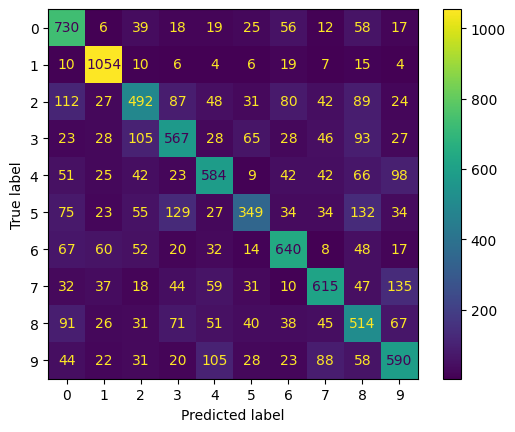

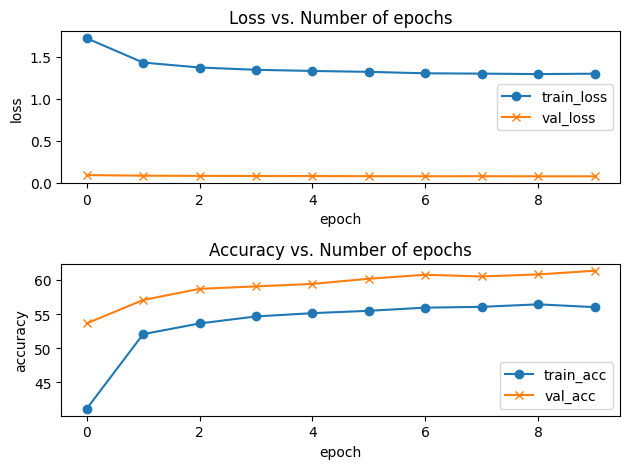

In [9]:
def main():
    # saving
    save_path = 'checkpoint/'

    # parser: add/modify any argument if you need
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
    parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
    parser.add_argument('--batch_size', type=int, default=16, help='batch size')
    parser.add_argument('--resume', default='', help='resume training from checkpoint')
    opt = parser.parse_args(
        args=[
            '--epochs', '10',
            '--lr', '1e-4',
            '--batch_size', '16',
            '--resume', ''
        ]
    )

    # check if GPU is available
    device = get_default_device()

    # transform and augmentation
    train_tfms, valid_tfms = data_trans_and_aug()

    # training / validation datasets
    train_ds = datasets.MNIST('./data', train=True, transform=train_tfms, download=True)
    valid_ds = datasets.MNIST('./data', train=False, transform=valid_tfms, download=True)

    # data loaders
    train_dl = DataLoader(train_ds, batch_size=opt.batch_size, shuffle=True, num_workers=1, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size=opt.batch_size, shuffle=False, num_workers=1, pin_memory=True)

    # model
    model = Net.to(device)

    # Start training
    results = Train(opt.epochs, opt.lr, model, device, train_dl, valid_dl, save_path, opt.resume)

    # Finish
    print("\nTraining Finish")

    # Analysis
    performance(model, valid_dl, device)
    plot_acc_and_lr(results)

if __name__ == '__main__':
    main()


